In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [34]:
data_path = '../data/../data/real_state_data_after_cleaning.csv'
df = pd.read_csv(data_path)
df.columns

Index(['precio', 'ambientes', 'no_baños', 'terreno_m2', 'año_constr',
       'no_dormitorios', 'area_constr_m2', 'estacionamientos', 'latitud',
       'longitud', 'tipo_de_propiedad', 'ofertado_como', 'ciudad', 'zona',
       'provincia', 'dpto'],
      dtype='object')

In [35]:
print(df.dpto.value_counts())
print(df.provincia.value_counts())

dpto
 Santa Cruz    1522
Name: count, dtype: int64
provincia
 Andrés Ibáñez    1522
Name: count, dtype: int64


Todas las columnas provienen del departamento de Santa Cruz y provincia Andrés Ibáñez. Se omiten estas variables.

In [36]:
#eligiendo las variables para el análisis
numerical = ['precio', 'ambientes', 'no_baños', 'terreno_m2', 'año_constr',
       'no_dormitorios', 'area_constr_m2', 'estacionamientos', 'latitud',
       'longitud']
num_continuous = ['precio', 'terreno_m2', 'area_constr_m2',  'latitud', 'longitud']
num_discrete = ['ambientes', 'no_baños', 'año_constr',
       'no_dormitorios', 'estacionamientos']
categorical = ['tipo_de_propiedad', 'ofertado_como', 'ciudad', 'zona']

### Valores Faltantes y DataTypes

Verificando valores faltantes.

In [37]:
df.isna().sum()

precio                  0
ambientes             800
no_baños                1
terreno_m2            761
año_constr              0
no_dormitorios          6
area_constr_m2          0
estacionamientos     1165
latitud                 0
longitud                0
tipo_de_propiedad       0
ofertado_como           0
ciudad                  0
zona                    5
provincia               0
dpto                    0
dtype: int64

Se procede a explorar ambientes, terreno y estacionamientos para vel el tipo de propiedad al que pertenecen y decidir sobre la técnica de imputación

In [38]:
#ver el terreno con valores faltantes
print('Terreno na:\n', df[df.terreno_m2.isna()].tipo_de_propiedad.value_counts(dropna=False), '\n')
print('Total:\n', df.tipo_de_propiedad.value_counts(dropna=False))

Terreno na:
 tipo_de_propiedad
Departamento            725
Casa                     26
Estudio/Monoambiente      7
Duplex                    3
Name: count, dtype: int64 

Total:
 tipo_de_propiedad
Departamento                  760
Casa                          690
Casa con Espacio Comercial     55
Estudio/Monoambiente           12
Duplex                          3
Penthouse                       2
Name: count, dtype: int64


Se tiene en total 760 propiedades del tipo departamento. De esas 760, 725 departamentos no tienen listado el terreno_m2. Por lo que es necesario explorar esos 35 departamentos que sí tienen terreno_m2.

In [39]:
print(len(df[(df['terreno_m2'].notna()) & (df['tipo_de_propiedad'] == 'Departamento') & 
             (df['terreno_m2'] == df['area_constr_m2'])]))

30


Como se puede observar, la mayoría de los departamentos que sí tienen terreno_m2 listado, 30 de 35, el valor de terreno m_2 coincide con el valor de area_cosntr_m2. De aquí se puede establecer la estratégia de repetir el valor del área_cosntr_m2 para el caso de los valores faltantes del terreno.

Adicionalmente se analizan las 26 casa con valores faltantes de terreno

In [40]:
df[(df['terreno_m2'].isna()) & (df['tipo_de_propiedad'] == 'Casa')].longitud.value_counts()

longitud
-63.178    23
-63.035     3
Name: count, dtype: int64

La mayoría pertenece a una sóla propiedad, 23 de 26. Luego se procederá a eliminar filas repetidas.

Se analizan las propiedades con estacionamiento faltantes.

In [41]:
print('Números de propiedades con estacinamiento faltante:')
df[(df['estacionamientos'].isna())].tipo_de_propiedad.value_counts()


Números de propiedades con estacinamiento faltante:


tipo_de_propiedad
Departamento                  716
Casa                          425
Casa con Espacio Comercial     13
Estudio/Monoambiente            8
Penthouse                       2
Duplex                          1
Name: count, dtype: int64

La mayoría son departamentos pero también casas. Se puede asumir que si el número de estacinamientos no viene listado, la propiedad no cuenta con estacionamientos, de otra forma se ofertaría con estos (los datos provienen de una página de ventas). En este caso, la técnica de imputación será remplazarlo con 0.

Finalmente se analiza el número de ambientes.

In [42]:
df[(df['ambientes'].isna())].tipo_de_propiedad.value_counts()

tipo_de_propiedad
Departamento                  548
Casa                          239
Casa con Espacio Comercial      7
Estudio/Monoambiente            3
Duplex                          3
Name: count, dtype: int64

Explorando para el caso de los departamentos.

In [43]:
df[(df['ambientes'].isna()) & 
       (df['tipo_de_propiedad']=='Departamento')
       ].terreno_m2.value_counts(dropna=False)

terreno_m2
NaN      546
63.06      1
34.0       1
Name: count, dtype: int64

Casi todos los departamentos con el número de ambientes faltante también tiene faltante el terreno.

In [44]:
print(df[(df['ambientes'].isna()) & 
       (df['tipo_de_propiedad']=='Departamento')
       ].no_dormitorios.value_counts(dropna=False))
print(df[(df['ambientes'].isna()) & 
       (df['tipo_de_propiedad']=='Departamento')
       ].no_baños.value_counts(dropna=False))

no_dormitorios
2.0    247
1.0    179
3.0    121
NaN      1
Name: count, dtype: int64
no_baños
2.0    361
1.0    169
3.0     16
4.0      2
Name: count, dtype: int64


Sin embargo, para los valores de baños y dormitorios si tienen valores. De esto, se podría asumir que es una omisión sistemática de esta información para el caso de departamentos.

In [45]:
len(df[(df['ambientes'] == df['no_baños']+df['no_dormitorios']) & 
       (df['tipo_de_propiedad']=='Casa')
       ])

77

Esto indica que sí hay una correlación entre el número de ambientes y el resto de las variable. Por lo que se usarán dos casos, utilizar KNNImputer o eliminar la columna entera.

Efectuando las imputaciones para efectos de la exploración de datos. Para la construcción del modelo, se usarán los datos sin imputar y se aplicará las imputaciones en el pipeline de scikitlearn.

In [46]:
df_1 = df[(df['no_baños'].notna()) & (df['no_dormitorios'].notna()) &
          (df['zona'].notna())].copy()
df_1['terreno_m2'].fillna(df['area_constr_m2'], inplace=True)
df_1['estacionamientos'].fillna(0, inplace=True)
df_1.drop('ambientes', axis=1, inplace=True)
df_1.head()

,precio,no_baños,terreno_m2,año_constr,no_dormitorios,area_constr_m2,estacionamientos,latitud,longitud,tipo_de_propiedad,ofertado_como,ciudad,zona,provincia,dpto
0,67000.0,2.0,320.0,2017,3.0,140.0,0.0,-17.769,-63.066,Casa,En Venta,Santa Cruz de la Sierra,Este,Andrés Ibáñez,Santa Cruz
1,67000.0,2.0,91.0,2018,2.0,91.0,0.0,-17.804,-63.157,Departamento,En Venta,Santa Cruz de la Sierra,Sur,Andrés Ibáñez,Santa Cruz
2,68000.0,2.0,193.0,2015,3.0,87.0,0.0,-17.836,-63.245,Casa,En Venta,Santa Cruz de la Sierra,Suroeste,Andrés Ibáñez,Santa Cruz
3,68000.0,1.0,62.83,2016,1.0,62.83,0.0,-17.755,-63.196,Departamento,En Venta,Santa Cruz de la Sierra,Equipetrol/NorOeste,Andrés Ibáñez,Santa Cruz
4,68000.0,2.0,300.0,2022,3.0,110.0,0.0,-17.653,-63.173,Casa,En Venta,Santa Cruz de la Sierra,Norte,Andrés Ibáñez,Santa Cruz


In [47]:
#Redefieniendo las variables de estudio
numerical = ['precio', 'no_baños', 'terreno_m2', 'año_constr',
       'no_dormitorios', 'area_constr_m2', 'estacionamientos', 'latitud',
       'longitud']
num_continuous = ['precio', 'terreno_m2', 'area_constr_m2',  'latitud', 'longitud']
num_discrete = ['no_baños', 'año_constr',
       'no_dormitorios', 'estacionamientos']
categorical = ['tipo_de_propiedad', 'ofertado_como', 'ciudad', 'zona']

Verificando el tipo de datos.

In [48]:
df_1[numerical].dtypes

precio              float64
no_baños            float64
terreno_m2           object
año_constr            int64
no_dormitorios      float64
area_constr_m2       object
estacionamientos    float64
latitud             float64
longitud            float64
dtype: object

In [49]:
df_2 = df_1.copy()
df_2['terreno_m2'] = df_1['terreno_m2'].str.replace(',', '.').astype(float)
df_2['area_constr_m2'] = df_1['area_constr_m2'].str.replace(',', '.').astype(float)
df_2[num_discrete] = df_2[num_discrete].astype('int')
df_2[numerical].dtypes

precio              float64
no_baños              int32
terreno_m2          float64
año_constr            int32
no_dormitorios        int32
area_constr_m2      float64
estacionamientos      int32
latitud             float64
longitud            float64
dtype: object

### Exploración Inicial de Datos

Se empieza con una descripción estadística de las varibles numéricas

In [50]:
df_2[numerical].describe()

,precio,no_baños,terreno_m2,año_constr,no_dormitorios,area_constr_m2,estacionamientos,latitud,longitud
count,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000
mean,93256.393117,2.145599,171.239405,2018.602912,2.754467,124.207113,0.608206,-17.652710,-62.996491
std,29955.894571,0.786462,124.551335,6.829899,1.398653,75.518978,3.457410,1.704762,3.777486
min,65.000000,1.000000,1.590000,1990.000000,1.000000,2.734000,0.000000,-17.914000,-103.337000
25%,68000.000000,2.000000,72.000000,2015.000000,2.000000,69.200000,0.000000,-17.795000,-63.192000
50%,95000.000000,2.000000,134.000000,2021.000000,3.000000,106.000000,0.000000,-17.768000,-63.178000
75%,123598.000000,3.000000,241.000000,2023.000000,3.000000,168.500000,0.000000,-17.745500,-63.153500
max,130000.000000,6.000000,974.950000,2025.000000,10.000000,846.000000,90.000000,20.561000,0.001000


Graficando las variables numéricas

In [51]:
enumerate(numerical)

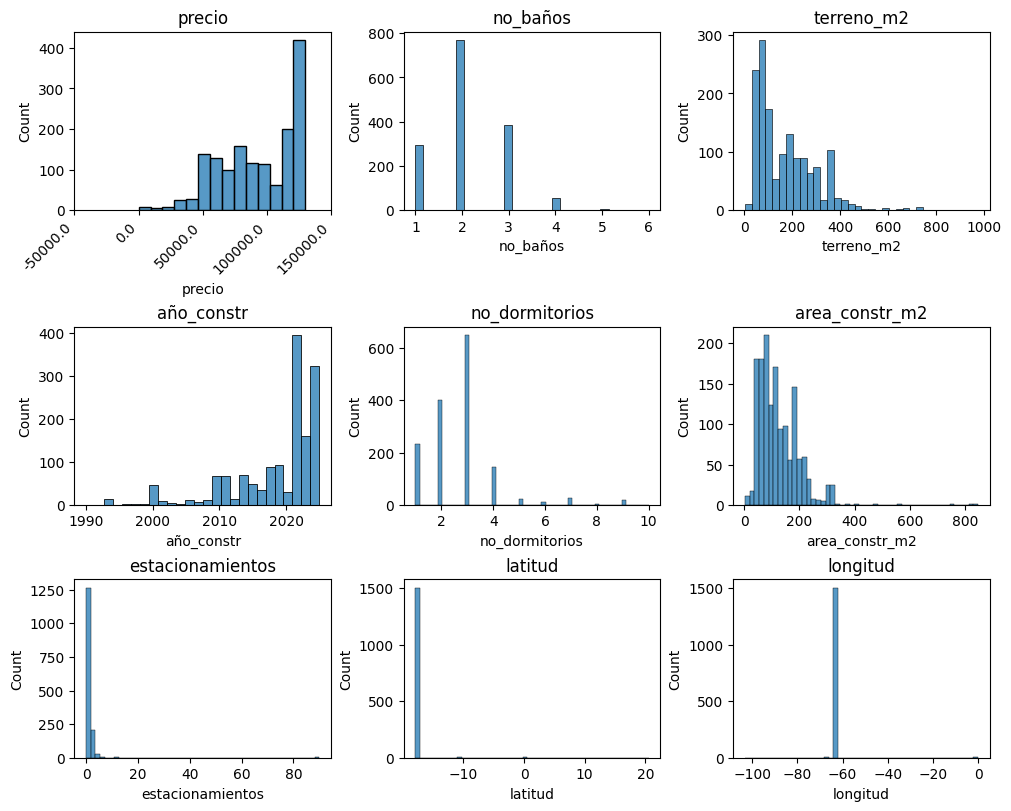

In [52]:
# Graficando datos cuantitativos
fig, axes = plt.subplots(3, 3, figsize=(10, 8), constrained_layout=True)

for i, var in enumerate(numerical):
    row = i // 3
    col = i % 3
    axes[row, col].set_title(var)
    if(i == 6 or i == 7 or i==8):
        sns.histplot(df_2[var], ax=axes[row, col], bins=50)
        continue
    sns.histplot(df_2[var], ax=axes[row, col])
    if i == 0:
        axes[row, col].set_xticks(axes[row, col].get_xticks())
        axes[row, col].set_xticklabels(axes[row, col].get_xticks(), rotation=45, ha='right')

        
plt.show()

<Axes: >

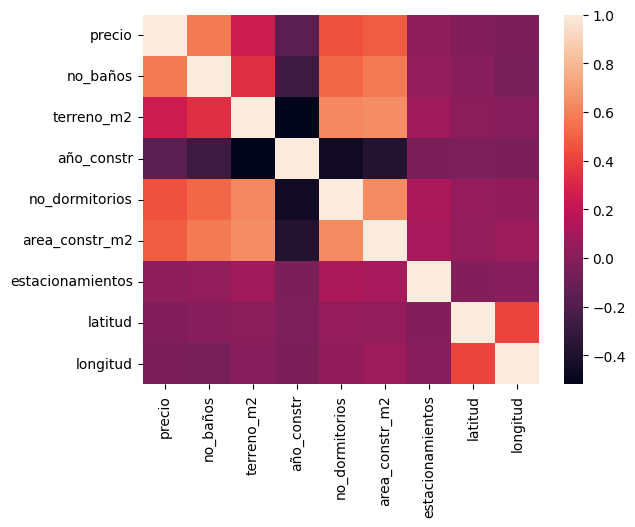

In [53]:
corr = df_2[numerical].corr()
sns.heatmap(corr)

<Axes: >

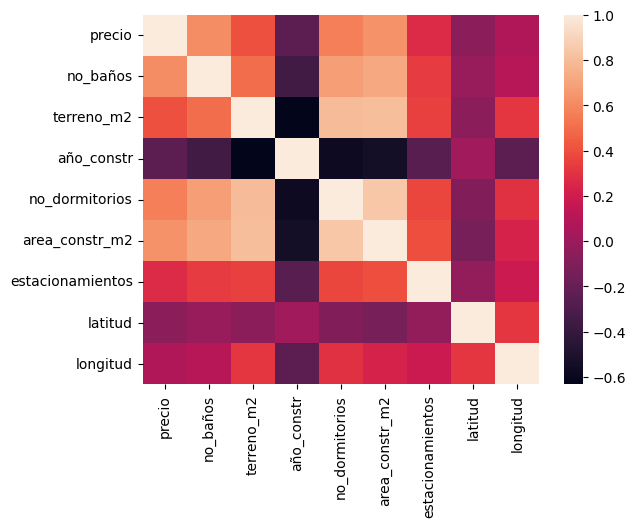

In [54]:
#Corelación spearman, debido a variables ordinales
corr = df_2[numerical].corr(method='spearman')
sns.heatmap(corr)

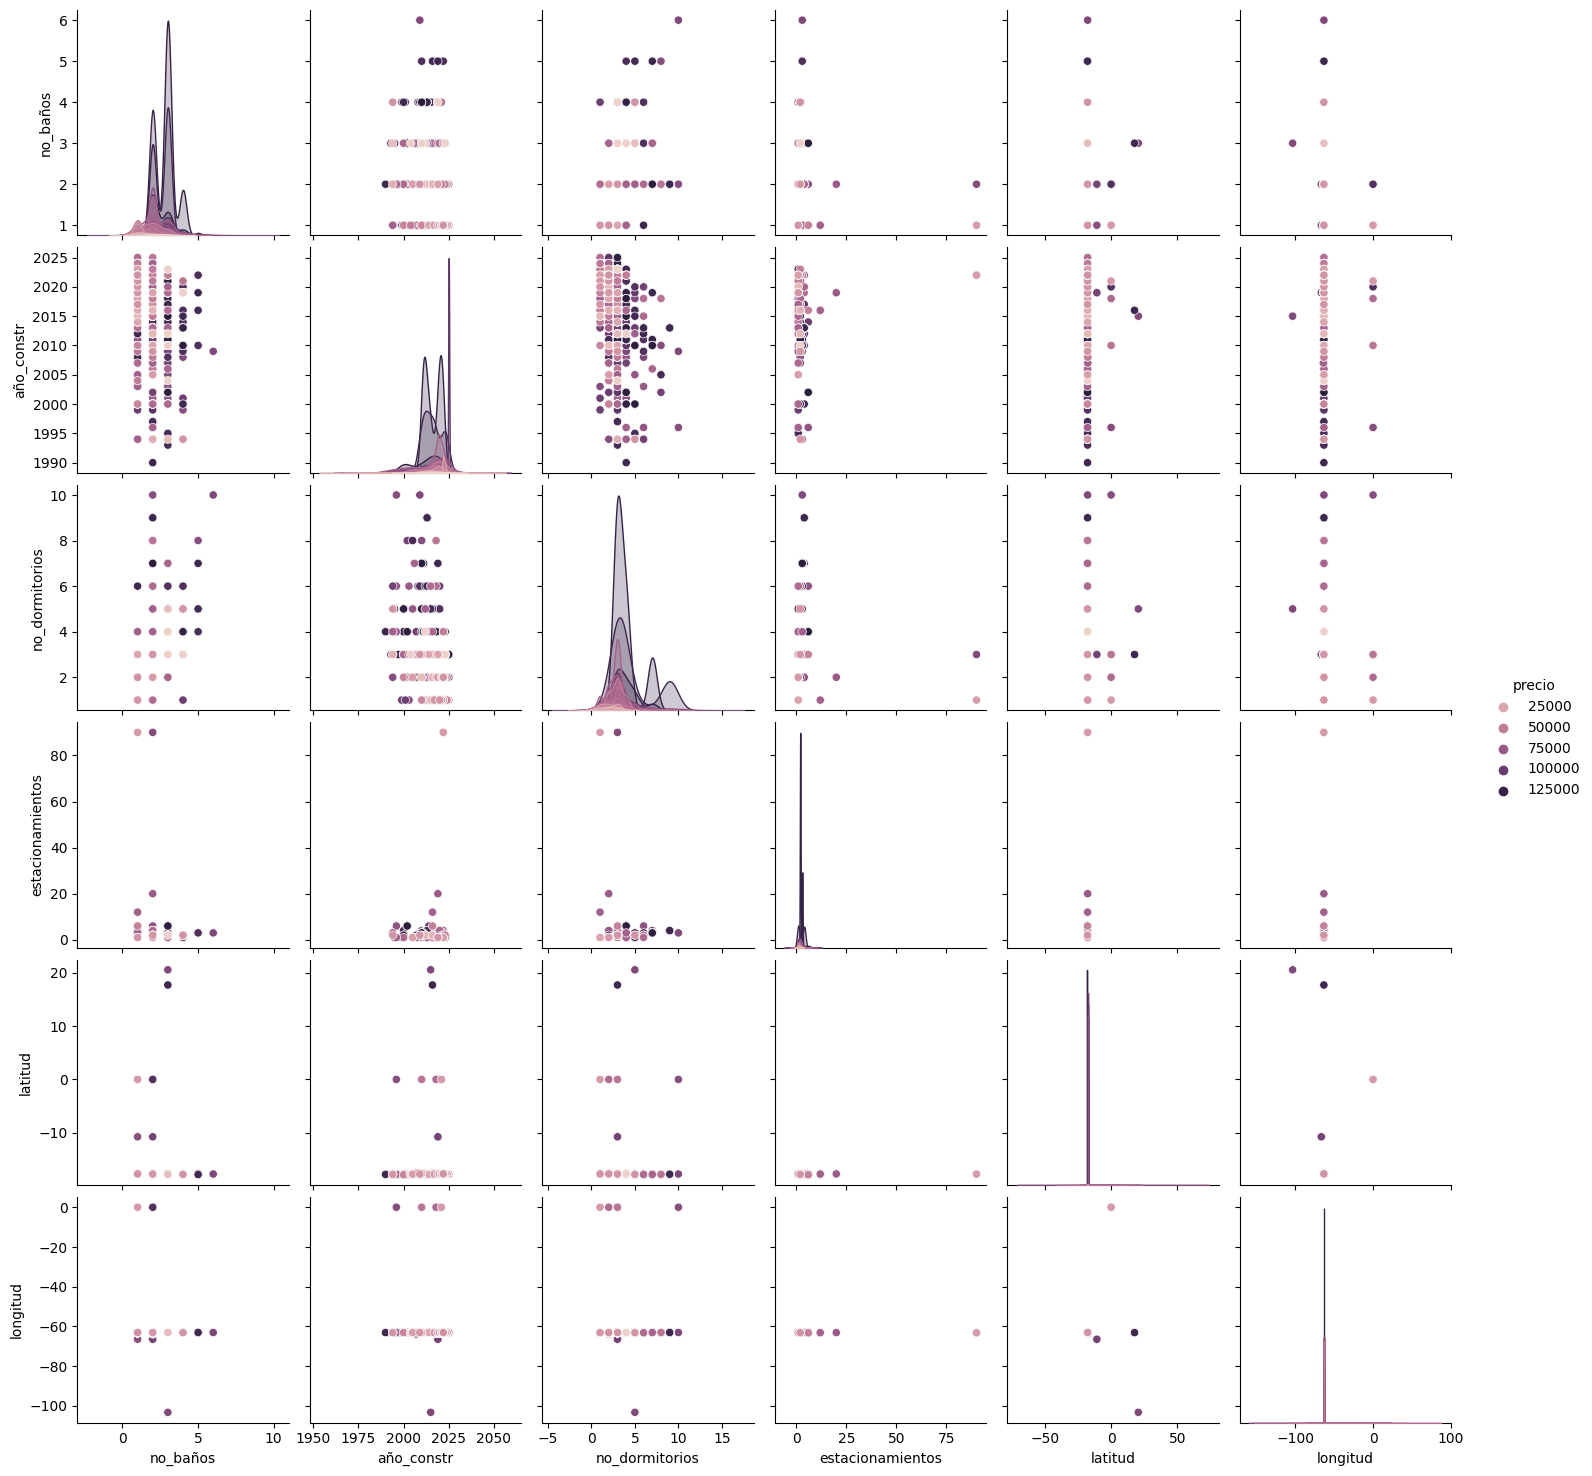

In [55]:
sns.pairplot(df[numerical], hue='precio')

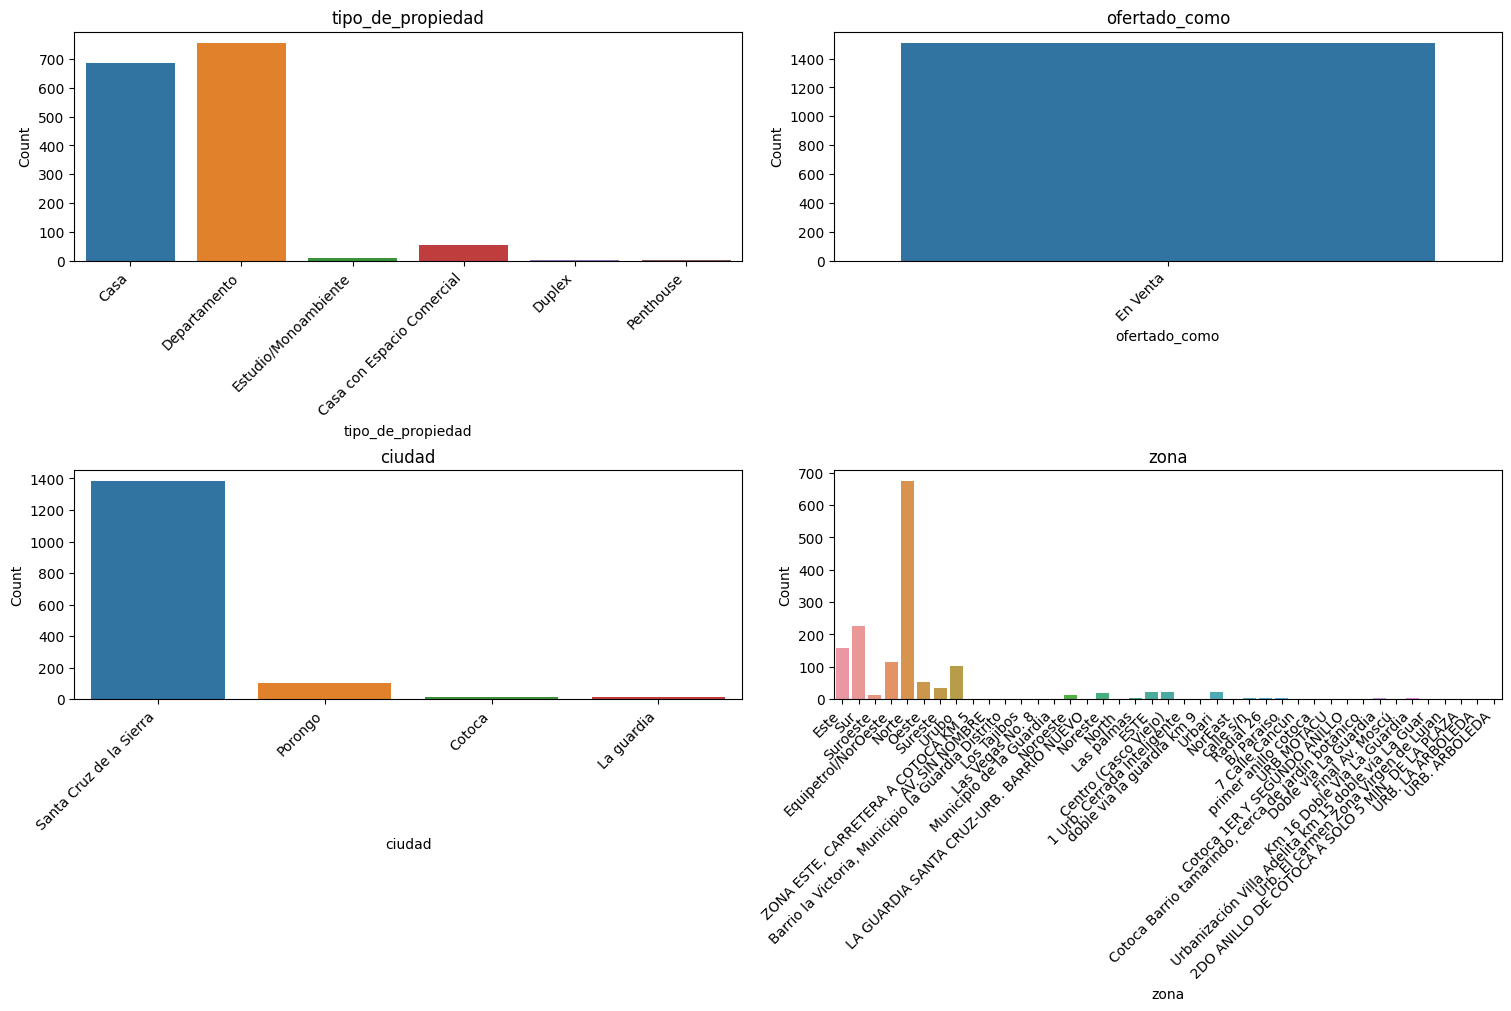

In [56]:
# Variables categóricas
fig, axes = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)

categorical = ['tipo_de_propiedad', 'ofertado_como', 'ciudad', 'zona']

for i, var in enumerate(categorical):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.countplot(x=var, data=df_2, ax=ax)  # Bar plot from DataFrame
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel("Count")
    ax.set_title(var)

plt.show()

Explorando la zona, se puede ver que existen valores que podrían considerarse inconsistente con la descripción de la variable. Se eliminan las categorias con menos de 5 valores.

In [57]:
s_zonas = df_2.zona.value_counts()
s_zonas[:4]

zona
Norte                  674
Sur                    225
Este                   158
Equipetrol/NorOeste    116
Name: count, dtype: int64

In [58]:
zonas = [zona for zona, value in s_zonas.items() if value > 4]
df_3 = df_2[df_2['zona'].isin(zonas)].copy()
df_3.zona.value_counts()

zona
Norte                   674
Sur                     225
Este                    158
Equipetrol/NorOeste     116
Urubo                   102
Oeste                    53
Sureste                  34
Centro (Casco Viejo)     23
Urbari                   23
ESTE                     21
Noreste                  19
Suroeste                 14
Noroeste                 13
Name: count, dtype: int64

Volviendo a graficar

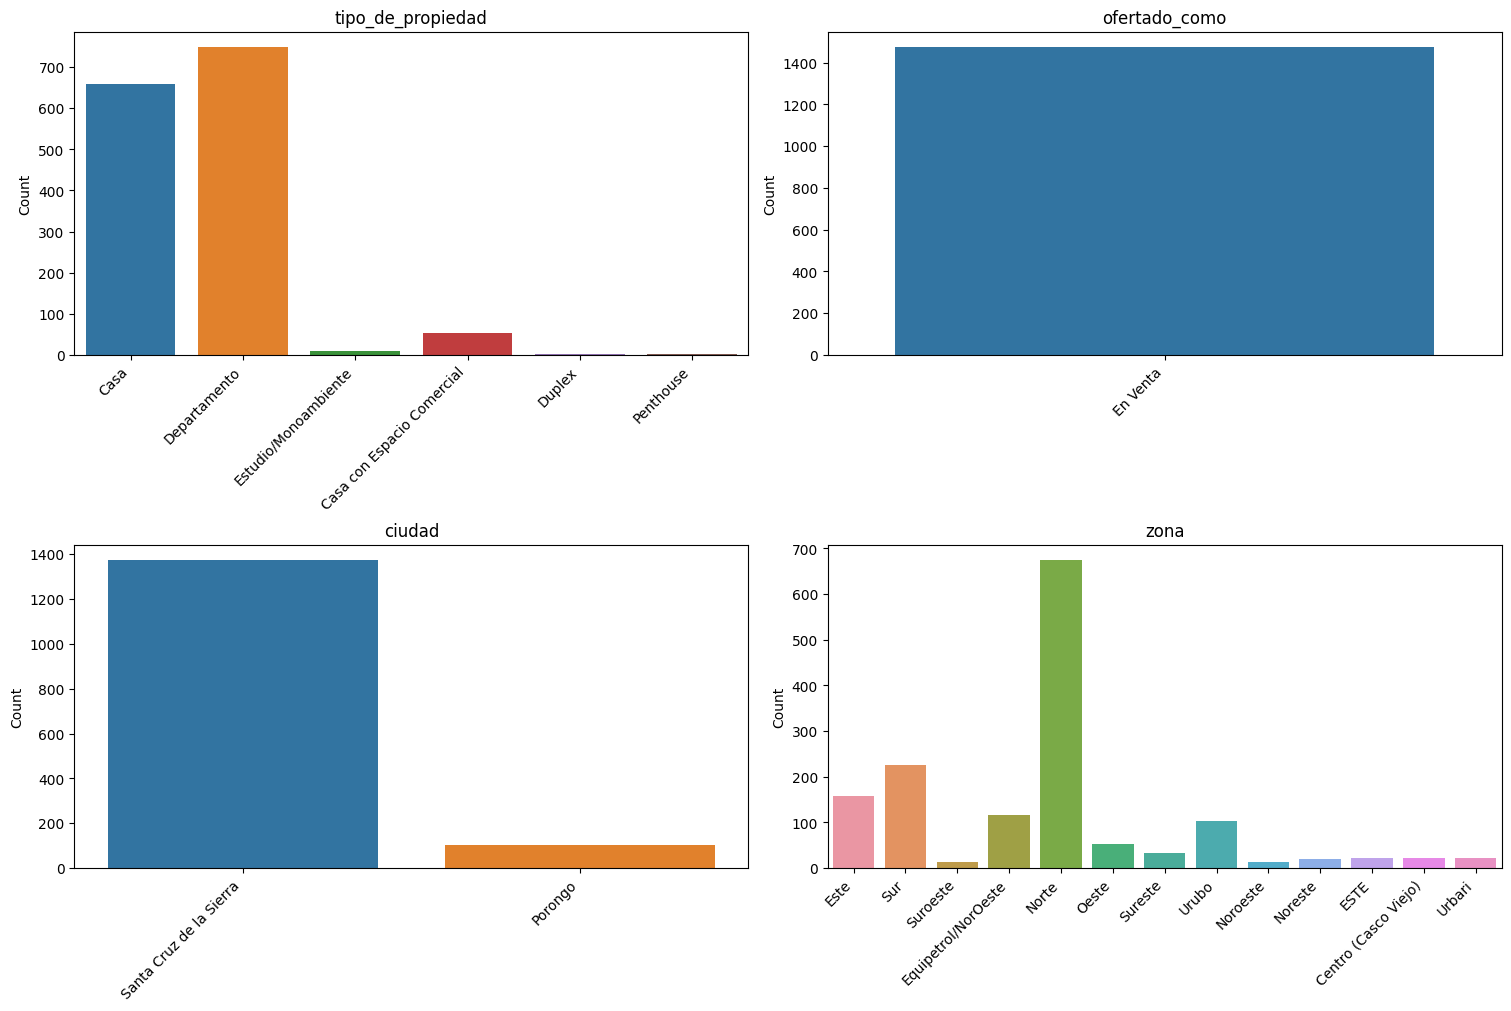

In [59]:
# Variables categóricas
fig, axes = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)

categorical = ['tipo_de_propiedad', 'ofertado_como', 'ciudad', 'zona']

for i, var in enumerate(categorical):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.countplot(x=var, data=df_3, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel(None)
    ax.set_ylabel("Count")
    ax.set_title(var)

plt.show()

Es interesante obtener un "violin plot" del número de cuartos y baños con respecto del precio

In [60]:
df_3.columns

Index(['precio', 'no_baños', 'terreno_m2', 'año_constr', 'no_dormitorios',
       'area_constr_m2', 'estacionamientos', 'latitud', 'longitud',
       'tipo_de_propiedad', 'ofertado_como', 'ciudad', 'zona', 'provincia',
       'dpto'],
      dtype='object')

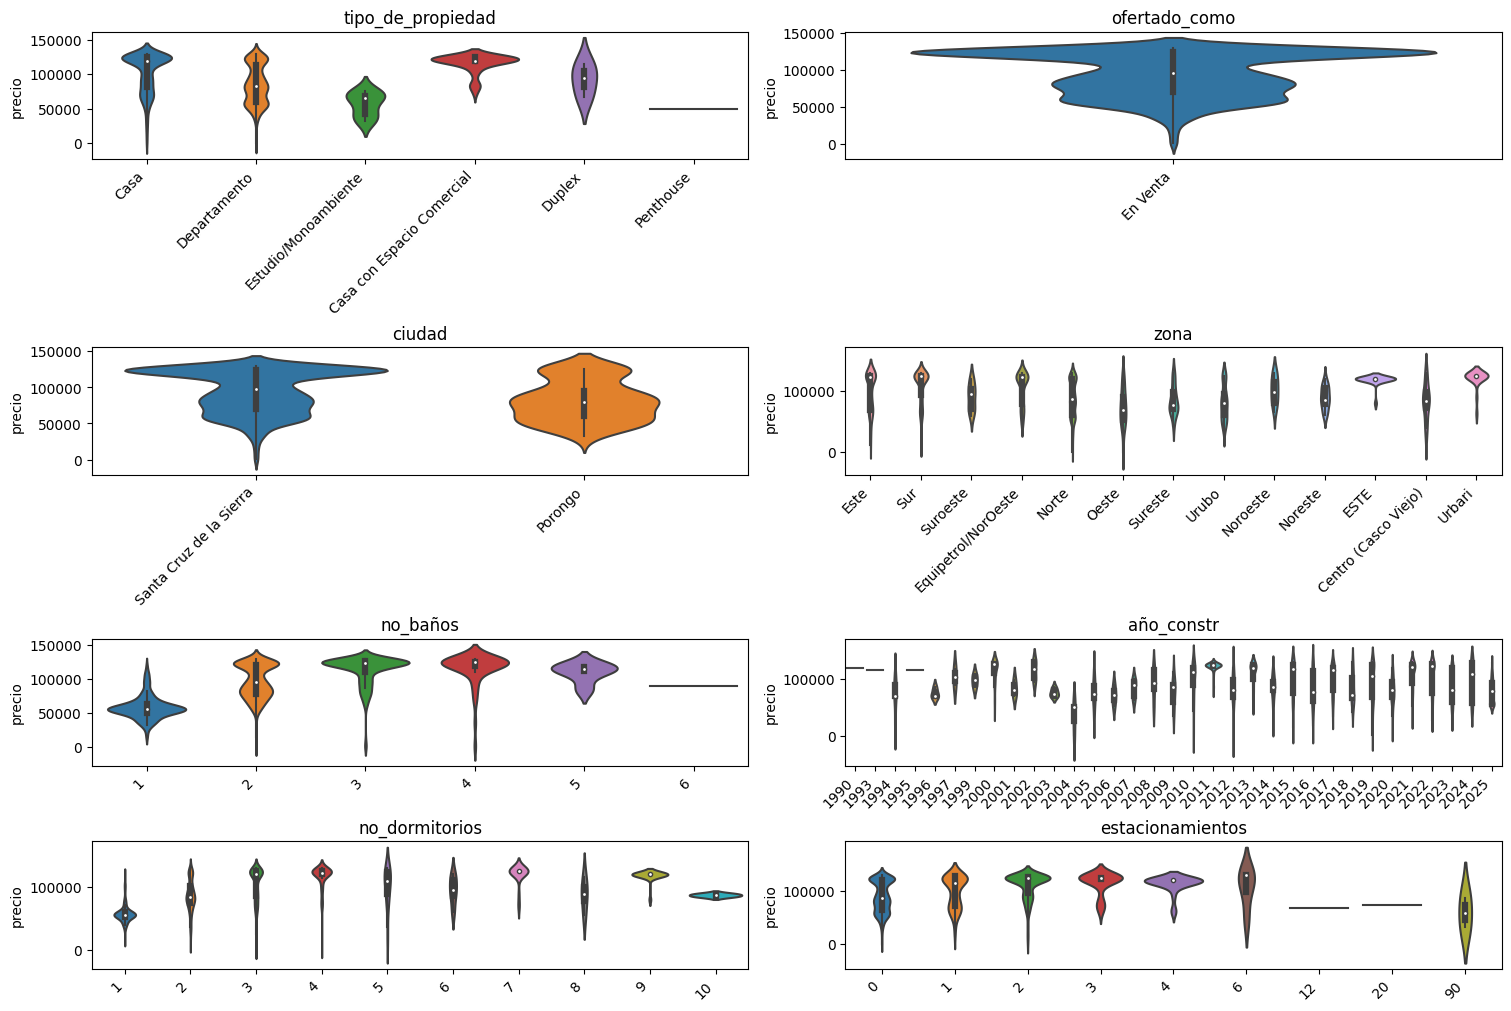

In [61]:
fig, axes = plt.subplots(4, 2, figsize=(15, 10), constrained_layout=True)

for i, var in enumerate(categorical + num_discrete):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.violinplot(x=var, y='precio', data=df_3, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel(None)
    ax.set_title(var)
plt.show()

Explorando la zona y el año de construcción

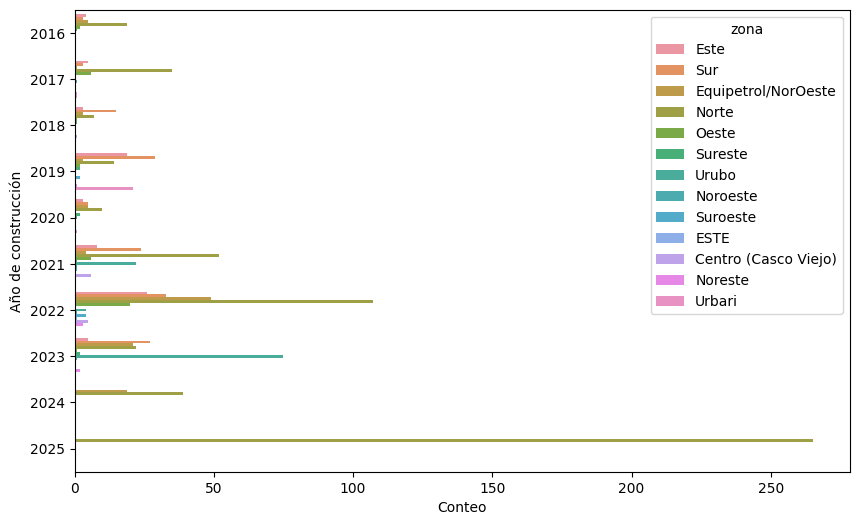

In [62]:
df_4 = df_3[df_3['año_constr']>2015]
plt.figure(figsize=(10, 6))
sns.countplot(data=df_4, y='año_constr', hue='zona')
plt.xlabel('Conteo')
plt.ylabel('Año de construcción')
plt.show()